# Анализ метрик обучающего приложения

**О приложении**

Анализ проводится для обучающего игрового приложения. Пользователи развивают свои навыки, при этом получают в приложении новые уровни. Приложение зарабатывает на продаже подсказок пользователям

**Цель проекта**

Изучение пользователей приложения и расчет основных метрик для улучшения финансовых показателей. Предстоит изучить получение новых уровней пользователями и связь этого процесса с метриками монетизации

**Исходные данные**

Четыре файла формата `csv`:

- `users`: информация о времени регистрации пользователей
- `sessions`: начало и конец каждой пользовательской сессии
- `payments`: время и величина платежей пользователями
- `levels`: дата перехода на новый уровень пользователем (и значение уровня)

## План работ

<font size = '4'>**Часть 1**</font>

**Ответы на теоретические вопросы**

<font size = '4'>**Часть 2**</font>

**Чтение и первичный анализ**

**Предобработка данных**

- Изучение и обработка пропусков в данных
- Преобразование типов
- Обработка неявных / явных дубликатов
- Исследование аномальных значений

**Исследовательский анализ**
- Расчет предварительных данных
- Retention rate и время в приложении
- Повышение уровня
- Метрики монетизации
- Распределение платежей по уровням
- Распределение первых платежей по уровням

**Общие выводы**

## Ответы на теоретические вопросы

**<font color = 'green'>1. Определение ARPPU. Снижение ARPPU -- хорошо или плохо?</font>**

- ARPPU (*average revenue per paying user*) -- это общая сумма денег, которую один платящий пользователь, в среднем, приносит бизнесу со всех своих покупок
- По определению ARPPU = (выручка с накоплением) / (количество платящих пользователей)
    - Снижение значения ARPPU может происходить по причинам:
        - увеличилось количество пользователей, которые покупают на меньшую сумму, чем прошлое значение ARPPU (появились такие новые пользователи, либо старые пользователи стали платить меньше)
        - уменьшилось количество пользователей, которые покупают больше, чем прошлое значение ARPPU (мы потеряли таких пользователей, либо старые пользователи стали платить меньше)
    - Если мы потеряли пользователей, которые приносят больше дохода, чем среднее значение -- **это очень плохо**, необходимо продумать, как их вернуть
    - Если старые пользователи стали платить меньше, чем до изменений в продукте -- **это плохо**, нужно сравнивать старую и новую продуктовую воронку и искать причины снижения
    - Если мы получили новых пользователей, которые платят меньше прошлого среднего значения -- **это прекрасно**: привлечь новых пользователей очень трудно, но у нас получилось! Остается понять, как подтолкнуть их к повышению трат в продукте



**<font color = 'green'>2. Обновление дизайна продукта привело к увеличению времени нахождения пользователей в приложении, при этом конверсия в покупку снизилась. Как это проанализировать, какие предложить рекомендации?</font>**

- Сперва следует сравнить продуктовые воронки для старого и нового дизайна: что случилось, где образовались узкие места?
- Затем посмотрим на распределения проведенного времени пользователями на страницах продукта: что стало работать лучше? Связано ли это с узкими местами, которые мы наметили на предыдущем шаге?
- Рекомендации будут в зависимости от наблюдений:
    - Если увеличение времени и снижение конверсии обязательно должны происходить одновременно, то это неудачное решение -- конверсия важнее
        - Альтернативно можно подумать над тем, как монетизировать проведенное время в приложении, чтобы не отказываться от новых решений (реклама внутри, если это подходит для продукта)
    - Если их можно разделить, то это отлично: нужно исправить узкие места в воронке, но оставить функционал, из-за которого пользователи больше проводят времени

## Чтение и первичный анализ данных

In [1]:
# pandas
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:,.2f}'.format

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# tool for date
from datetime import timedelta

# numpy
import numpy as np

In [2]:
users = pd.read_csv('/Users/ilatti/Documents/workshop/dataset/users.csv', index_col=[0])
sessions = pd.read_csv('/Users/ilatti/Documents/workshop/dataset/sessions.csv', index_col=[0])
payments = pd.read_csv('/Users/ilatti/Documents/workshop/dataset/payments.csv', index_col=[0])
levels = pd.read_csv('/Users/ilatti/Documents/workshop/dataset/levels.csv', index_col=[0])

In [3]:
def basic_info(df):
    print(df.info())
    display(df.head())

In [4]:
basic_info(users)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31114 entries, 0 to 31114
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   31114 non-null  int64 
 1   reg_time  31114 non-null  object
dtypes: int64(1), object(1)
memory usage: 729.2+ KB
None


,user_id,reg_time
0,439127,2023-05-16 15:47:56.024
1,646681,2023-05-16 16:32:35.495
2,35136,2023-05-16 16:50:14.571
3,933255,2023-05-16 03:28:56.790
4,59440,2023-05-16 06:53:22.412


In [5]:
basic_info(sessions)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358004 entries, 0 to 358033
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     358004 non-null  int64 
 1   close_time  358004 non-null  object
 2   open_time   358004 non-null  object
dtypes: int64(1), object(2)
memory usage: 10.9+ MB
None


,user_id,close_time,open_time
0,875013,2023-05-16 05:17:59,2023-05-16 05:06:09
1,138278,2023-05-16 06:48:24,2023-05-16 06:47:34
2,138278,2023-05-18 01:44:40,2023-05-18 01:07:58
3,138278,2023-05-18 05:02:58,2023-05-18 04:51:06
4,138278,2023-05-19 05:58:32,2023-05-19 05:46:19


In [6]:
basic_info(payments)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 1 to 699
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   699 non-null    int64  
 1   pay_time  699 non-null    object 
 2   amt       699 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 21.8+ KB
None


,user_id,pay_time,amt
1,107907,2023-05-29 17:08:18.890,0.40
2,510991,2023-05-20 16:55:01.216,0.20
3,294837,2023-05-19 01:41:55.970,0.20
4,644287,2023-05-20 03:01:53.697,0.20
5,673424,2023-05-20 03:33:36.918,0.10


In [7]:
basic_info(levels)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130623 entries, 0 to 130629
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  130623 non-null  int64  
 1   time     130623 non-null  object 
 2   level    130623 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.0+ MB
None


,user_id,time,level
0,105194,2023-05-16 08:22:12.799003,2.00
1,105194,2023-05-16 08:26:42.405003,3.00
2,105194,2023-05-16 08:27:12.760003,4.00
3,991914,2023-05-16 09:06:38.315003,2.00
4,991914,2023-05-16 09:09:39.832003,3.00


- Даты записаны строкой, приведем к `datetime`
- Значение уровня пользователя записано в `float`, преобразуем в `int`
- В данных нет пропусков 

## Предобработка данных

### Преобразование типов

Приведем дату к удобному формату

In [8]:
for i in [users, sessions, payments, levels]:
    for j in list(i.select_dtypes(['object']).columns):
        i[j] = pd.to_datetime(i[j], format='%Y-%m-%d %H:%M:%S')
        i[j] = i[j].dt.floor('s')
    basic_info(i)
    print('-' * 50)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31114 entries, 0 to 31114
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   31114 non-null  int64         
 1   reg_time  31114 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 729.2 KB
None


,user_id,reg_time
0,439127,2023-05-16 15:47:56
1,646681,2023-05-16 16:32:35
2,35136,2023-05-16 16:50:14
3,933255,2023-05-16 03:28:56
4,59440,2023-05-16 06:53:22


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 358004 entries, 0 to 358033
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     358004 non-null  int64         
 1   close_time  358004 non-null  datetime64[ns]
 2   open_time   358004 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 10.9 MB
None


,user_id,close_time,open_time
0,875013,2023-05-16 05:17:59,2023-05-16 05:06:09
1,138278,2023-05-16 06:48:24,2023-05-16 06:47:34
2,138278,2023-05-18 01:44:40,2023-05-18 01:07:58
3,138278,2023-05-18 05:02:58,2023-05-18 04:51:06
4,138278,2023-05-19 05:58:32,2023-05-19 05:46:19


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 1 to 699
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   699 non-null    int64         
 1   pay_time  699 non-null    datetime64[ns]
 2   amt       699 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 21.8 KB
None


,user_id,pay_time,amt
1,107907,2023-05-29 17:08:18,0.40
2,510991,2023-05-20 16:55:01,0.20
3,294837,2023-05-19 01:41:55,0.20
4,644287,2023-05-20 03:01:53,0.20
5,673424,2023-05-20 03:33:36,0.10


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 130623 entries, 0 to 130629
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   user_id  130623 non-null  int64         
 1   time     130623 non-null  datetime64[ns]
 2   level    130623 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 4.0 MB
None


,user_id,time,level
0,105194,2023-05-16 08:22:12,2.00
1,105194,2023-05-16 08:26:42,3.00
2,105194,2023-05-16 08:27:12,4.00
3,991914,2023-05-16 09:06:38,2.00
4,991914,2023-05-16 09:09:39,3.00


--------------------------------------------------


Уровни исчисляются натуральными числами или есть дробные?

In [9]:
levels.level.value_counts()

2.00     25534
3.00     21366
4.00     17862
5.00     14438
6.00     12729
7.00     12083
8.00     10327
9.00      6598
10.00     4034
11.00     2636
12.00     1553
13.00      795
14.00      384
15.00      173
16.00       74
17.00       22
18.00        7
19.00        5
20.00        2
21.00        1
Name: level, dtype: int64

Сделаем запись уровня в целочисленном формате

In [10]:
levels.level = levels.level.astype('int')
basic_info(levels)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130623 entries, 0 to 130629
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   user_id  130623 non-null  int64         
 1   time     130623 non-null  datetime64[ns]
 2   level    130623 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.0 MB
None


,user_id,time,level
0,105194,2023-05-16 08:22:12,2
1,105194,2023-05-16 08:26:42,3
2,105194,2023-05-16 08:27:12,4
3,991914,2023-05-16 09:06:38,2
4,991914,2023-05-16 09:09:39,3


### Обработка дубликатов

Единственная таблица, где могут быть неявные дубликаты -- `users`, могут быть продублированы регистрации пользователей; проверим

In [11]:
users.duplicated(subset='user_id').sum()

0

- Неявных дубликатов нет
- Проверим наличие полных явных дубликатов в оставшихся данных

In [12]:
for i in [sessions, payments, levels]:
    print(i.duplicated().sum())
    print('-' * 50)

0
--------------------------------------------------
0
--------------------------------------------------
0
--------------------------------------------------


В данных нет дубликатов

### Аномальные значения

- Посмотрим распределение проведенного времени в приложении
- Введем дополнительный столбец, в котором рассчитаем время как разницу между концом и началом сессии

In [13]:
sessions['spent_time_minutes'] = sessions.close_time - sessions.open_time
sessions.spent_time_minutes = (round(sessions.spent_time_minutes
                                     .dt
                                     .total_seconds() / 60, 1))
sessions.head()

,user_id,close_time,open_time,spent_time_minutes
0,875013,2023-05-16 05:17:59,2023-05-16 05:06:09,11.80
1,138278,2023-05-16 06:48:24,2023-05-16 06:47:34,0.80
2,138278,2023-05-18 01:44:40,2023-05-18 01:07:58,36.70
3,138278,2023-05-18 05:02:58,2023-05-18 04:51:06,11.90
4,138278,2023-05-19 05:58:32,2023-05-19 05:46:19,12.20


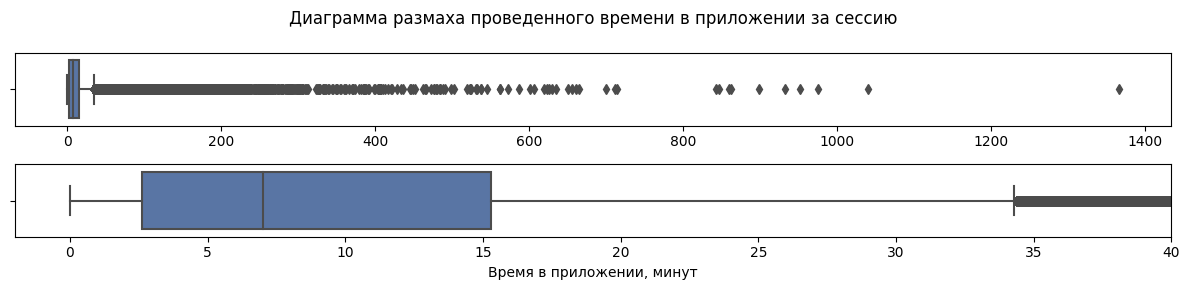

In [14]:
fig, ax = plt.subplots(2, 1)
fig.set(size_inches=(12, 3), tight_layout=True)
sns.set_palette('deep')

sns.boxplot(data=sessions, x='spent_time_minutes', ax=ax[0]);
ax[0].set(xlabel=None, title='Диаграмма размаха проведенного времени в приложении за сессию\n');

sns.boxplot(data=sessions, x='spent_time_minutes', ax=ax[1]);
ax[1].set(xlabel='Время в приложении, минут', xlim=(-2, 40));

In [15]:
sessions.spent_time_minutes.describe()

count   358,004.00
mean         12.51
std          19.52
min           0.00
25%           2.60
50%           7.00
75%          15.30
max       1,365.30
Name: spent_time_minutes, dtype: float64

- 75 % пользователей за сессию проводят в приложении менее 15 минут и 18 секунд
- Медианное время сессии составляет семь минут
- Существуют аномально длительные сессии: 10 часов и более
- Из-за выбросов среднее больше медианы: около 13 минут

Рассчитаем процентили, характеризующие аномальных пользователей (у которых встречаются длинные сессии):

In [16]:
percentile = pd.DataFrame([[95, 0], [99, 0]])
percentile.columns = ['percentile', 'spent_time_minutes']
percentile['spent_time_minutes'] = np.percentile(sessions.spent_time_minutes, [95, 99])
percentile

,percentile,spent_time_minutes
0,95,41.80
1,99,81.90


- Видим, что 95 % сессий длятся менее 41.8 минут
- При этом 99 % менее 81.9 минут
- Запишем айди пользователей, у которых были сессии более 81.9 минут:

In [17]:
abnormal_users = sessions.query('spent_time_minutes > 81.9').user_id # от дубликатов избавимся позднее

In [18]:
basic_info(abnormal_users)

<class 'pandas.core.series.Series'>
Int64Index: 3578 entries, 279 to 357791
Series name: user_id
Non-Null Count  Dtype
--------------  -----
3578 non-null   int64
dtypes: int64(1)
memory usage: 55.9 KB
None


279    751772
290    751772
710    643705
797    391265
841    234513
Name: user_id, dtype: int64

Посмотрим подробнее на траты пользователей

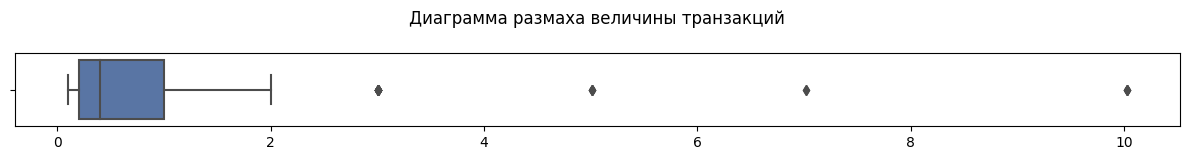

In [19]:
fig, ax = plt.subplots()
fig.set(size_inches=(12, 1.7), tight_layout=True)


sns.boxplot(data=payments, x='amt', ax=ax);
ax.set(xlabel=None, title='Диаграмма размаха величины транзакций\n');

In [20]:
percentile = pd.DataFrame([[95, 0], [99, 0]])
percentile.columns = ['percentile', 'payment_amt']
percentile['payment_amt'] = np.percentile(payments.amt, [95, 99])
percentile

,percentile,payment_amt
0,95,2.00
1,99,5.01


- Почти все пользователи не тратят больше 2 у.е. -- 95 % выборки
- Добавим айди тех пользователей, которые совершали покупки на сумму больше 5.01 у.е.

In [21]:
abnormal_users = pd.concat([abnormal_users, payments.query('amt > 5.01').user_id])

In [22]:
basic_info(abnormal_users)

<class 'pandas.core.series.Series'>
Int64Index: 3588 entries, 279 to 461
Series name: user_id
Non-Null Count  Dtype
--------------  -----
3588 non-null   int64
dtypes: int64(1)
memory usage: 56.1 KB
None


279    751772
290    751772
710    643705
797    391265
841    234513
Name: user_id, dtype: int64

Изучим значения уровней, которые получают пользователи:

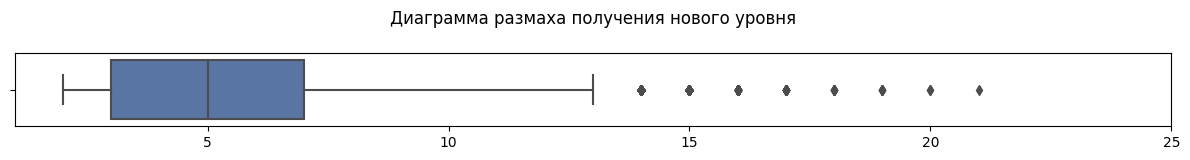

In [23]:
fig, ax = plt.subplots()
fig.set(size_inches=(12, 1.7), tight_layout=True)


sns.boxplot(data=levels, x='level', ax=ax);
ax.set(xlabel=None, title='Диаграмма размаха получения нового уровня\n', xlim=(1, 25));

In [24]:
percentile = pd.DataFrame([[95, 0], [99, 0]])
percentile.columns = ['percentile', 'level']
percentile['level'] = np.percentile(levels.level, [95, 99])
percentile

,percentile,level
0,95,10.00
1,99,13.00


- Только 5 % пользователей получают уровень больше 10-го
- Добавим айди пользователей, получивших уровень больше 13-го

In [25]:
abnormal_users = pd.concat([abnormal_users, levels.query('level > 13').user_id])

In [26]:
basic_info(abnormal_users)

<class 'pandas.core.series.Series'>
Int64Index: 4256 entries, 279 to 130559
Series name: user_id
Non-Null Count  Dtype
--------------  -----
4256 non-null   int64
dtypes: int64(1)
memory usage: 66.5 KB
None


279    751772
290    751772
710    643705
797    391265
841    234513
Name: user_id, dtype: int64

Избавимся от дубликатов

In [27]:
abnormal_users = abnormal_users.drop_duplicates()
basic_info(abnormal_users)

<class 'pandas.core.series.Series'>
Int64Index: 2216 entries, 279 to 130556
Series name: user_id
Non-Null Count  Dtype
--------------  -----
2216 non-null   int64
dtypes: int64(1)
memory usage: 34.6 KB
None


279    751772
710    643705
797    391265
841    234513
906    412445
Name: user_id, dtype: int64

Напишем функции: 
- для удаления аномальных пользователей из всех файлов
- для расчета потерь от начальных данных после этого

In [28]:
def discard_users(users, sessions, payments, levels, id_list):
    users = users[~users['user_id'].isin(id_list)]
    sessions = sessions[~sessions['user_id'].isin(id_list)]
    payments = payments[~payments['user_id'].isin(id_list)]
    levels = levels[~levels['user_id'].isin(id_list)]
    
    return(users, sessions, payments, levels)

In [29]:
def count_losses(users, sessions, payments, levels, 
                 users_init, sessions_init, payments_init, levels_init):
    print('users\n')
    print(f'Строк отброшено: {users_init.shape[0] - users.shape[0]} ({((users_init.shape[0] - users.shape[0]) / users_init.shape[0]):.1%})')
    print('-' * 50)
    
    print('sessions\n')
    print(f'Строк отброшено: {sessions_init.shape[0] - sessions.shape[0]} ({((sessions_init.shape[0] - sessions.shape[0]) / sessions_init.shape[0]):.1%})')
    print(f'Пользователей отброшено: {sessions_init.user_id.nunique() - sessions.user_id.nunique()} ({((sessions_init.user_id.nunique() - sessions.user_id.nunique()) / sessions_init.user_id.nunique()):.1%})')
    print('-' * 50)
    
    print('payments\n')
    print(f'Строк отброшено: {payments_init.shape[0] - payments.shape[0]} ({((payments_init.shape[0] - payments.shape[0]) / payments_init.shape[0]):.1%})')
    print(f'Пользователей отброшено: {payments_init.user_id.nunique() - payments.user_id.nunique()} ({((payments_init.user_id.nunique() - payments.user_id.nunique()) / payments_init.user_id.nunique()):.1%})')
    print('-' * 50)
    
    print('levels\n')
    print(f'Строк отброшено: {levels_init.shape[0] - levels.shape[0]} ({((levels_init.shape[0] - levels.shape[0]) / levels_init.shape[0]):.1%})')
    print(f'Пользователей отброшено: {levels_init.user_id.nunique() - levels.user_id.nunique()} ({((levels_init.user_id.nunique() - levels.user_id.nunique()) / levels_init.user_id.nunique()):.1%})')
    print('-' * 50)
    
    print('total\n')
    print(f'Строк отброшено: {users_init.shape[0] + sessions_init.shape[0] + payments_init.shape[0] + levels_init.shape[0] - users.shape[0] - sessions.shape[0] - payments.shape[0] - levels.shape[0]} ({((users_init.shape[0] + sessions_init.shape[0] + payments_init.shape[0] + levels_init.shape[0] - users.shape[0] - sessions.shape[0] - payments.shape[0] - levels.shape[0]) / (users_init.shape[0] + sessions_init.shape[0] + payments_init.shape[0] + levels_init.shape[0])):.1%})')

In [30]:
users_init = users.copy()
sessions_init = sessions.copy()
payments_init = payments.copy()
levels_init = levels.copy()

In [31]:
users, sessions, payments, levels = discard_users(users, sessions, payments, levels, abnormal_users)

In [32]:
count_losses(users, sessions, payments, levels, 
                 users_init, sessions_init, payments_init, levels_init)

users

Строк отброшено: 2216 (7.1%)
--------------------------------------------------
sessions

Строк отброшено: 93744 (26.2%)
Пользователей отброшено: 2216 (7.1%)
--------------------------------------------------
payments

Строк отброшено: 367 (52.5%)
Пользователей отброшено: 124 (39.7%)
--------------------------------------------------
levels

Строк отброшено: 21456 (16.4%)
Пользователей отброшено: 2213 (8.7%)
--------------------------------------------------
total

Строк отброшено: 117783 (22.6%)


- Подход привел к потере критического количества записей (больше 10 %)
- Оптимально отбросить 5 % строк
- Скорректируем границу аномальности с 99-го процентиля -- перейдем к дробным значениям, чтобы выйти на 5 % потерь

In [33]:
users = users_init.copy()
sessions = sessions_init.copy()
payments = payments_init.copy()
levels = levels_init.copy()

In [34]:
abnormal_users = pd.Series(dtype='float')
for i in [[sessions, 'spent_time_minutes'], [payments, 'amt'], [levels, 'level']]:
    percentile = 99.9
    threshold = np.percentile(i[0][i[1]], percentile)
    abnormal_users = pd.concat([abnormal_users, i[0][i[0][i[1]] > threshold].user_id])

In [35]:
users, sessions, payments, levels = discard_users(users, sessions, payments, levels, abnormal_users)

In [36]:
count_losses(users, sessions, payments, levels, 
                 users_init, sessions_init, payments_init, levels_init)

users

Строк отброшено: 290 (0.9%)
--------------------------------------------------
sessions

Строк отброшено: 17800 (5.0%)
Пользователей отброшено: 290 (0.9%)
--------------------------------------------------
payments

Строк отброшено: 117 (16.7%)
Пользователей отброшено: 31 (9.9%)
--------------------------------------------------
levels

Строк отброшено: 3238 (2.5%)
Пользователей отброшено: 290 (1.1%)
--------------------------------------------------
total

Строк отброшено: 21445 (4.1%)


Оставляем в таком виде

Наконец, изучим временные интервалы сессий и регистраций:

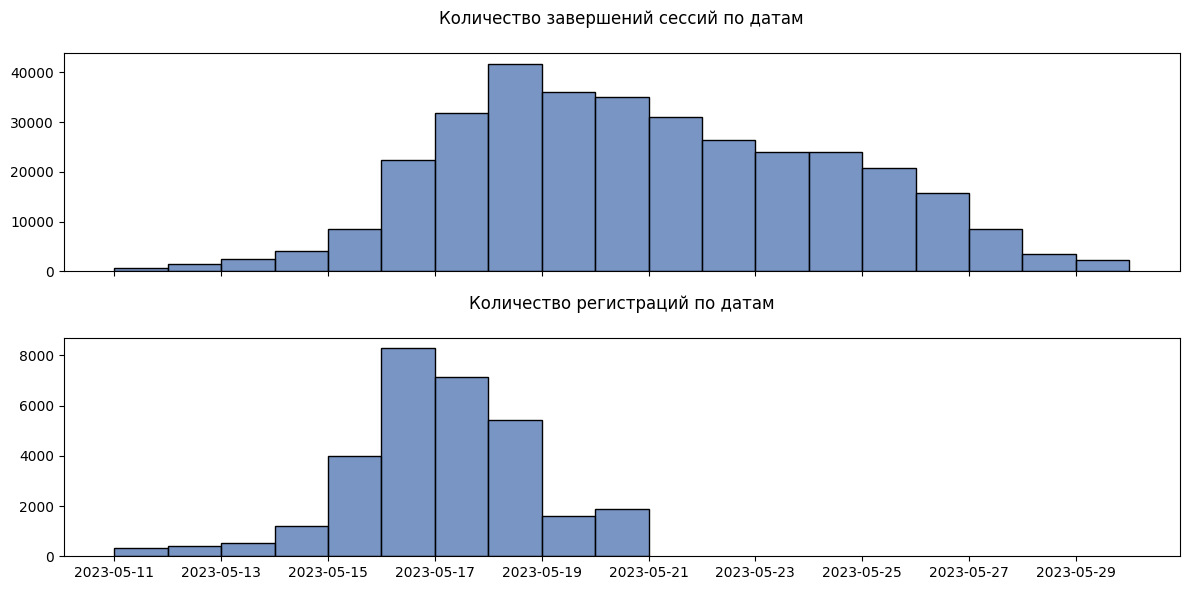

In [37]:
sessions['close_time_date'] = sessions.close_time.dt.normalize()
users['reg_time_date'] = users.reg_time.dt.normalize()


fig, ax = plt.subplots(2, 1, sharex=True)
fig.set(size_inches=(12, 6), tight_layout=True)

sns.histplot(data=sessions, x='close_time_date', ax=ax[0], binwidth=1);
ax[0].set(ylabel=None, xlabel=None, title='Количество завершений сессий по датам\n');

sns.histplot(data=users, x='reg_time_date', ax=ax[1], binwidth=1);
ax[1].set(ylabel=None, xlabel=None, title='Количество регистраций по датам\n');

- Датасет охватывает период использования с 11 по 29 мая 2023 
- Регистрация новых пользователей началась 11 мая и закончилась 20 мая

## Исследовательский анализ

### Подготовка предварительных данных

- Для решения поставленных задач нужно получить сводные таблицы с лайфтаймами пользователей в столбцах, `user_id` в индексах и необходимыми значениями в ячейках
- Сначала добавим значение лайфтайма в таблицы с сессиями, транзакциями и уровнями
    - Для этого добавим в таблицы `timestamp` регистрации и отнимем его от `timestamp` получения уровня/транзакции/начала сессии

In [38]:
def lifetime_calculation(df, column):
    df = df.merge(users[['user_id', 'reg_time']], on='user_id', how='left')
    df['lifetime'] = (df[column] - df.reg_time).dt.days
    return(df)

In [39]:
sessions = lifetime_calculation(sessions, 'open_time')
sessions.head()

,user_id,close_time,open_time,spent_time_minutes,close_time_date,reg_time,lifetime
0,875013,2023-05-16 05:17:59,2023-05-16 05:06:09,11.80,2023-05-16,2023-05-16 05:06:09,0
1,138278,2023-05-16 06:48:24,2023-05-16 06:47:34,0.80,2023-05-16,2023-05-16 06:47:34,0
2,138278,2023-05-18 01:44:40,2023-05-18 01:07:58,36.70,2023-05-18,2023-05-16 06:47:34,1
3,138278,2023-05-18 05:02:58,2023-05-18 04:51:06,11.90,2023-05-18,2023-05-16 06:47:34,1
4,138278,2023-05-19 05:58:32,2023-05-19 05:46:19,12.20,2023-05-19,2023-05-16 06:47:34,2


In [40]:
payments = lifetime_calculation(payments, 'pay_time')
payments.head()

,user_id,pay_time,amt,reg_time,lifetime
0,107907,2023-05-29 17:08:18,0.40,2023-05-20 20:21:33,8
1,510991,2023-05-20 16:55:01,0.20,2023-05-19 20:26:36,0
2,644287,2023-05-20 03:01:53,0.20,2023-05-20 01:36:12,0
3,673424,2023-05-20 03:33:36,0.10,2023-05-18 01:22:31,2
4,29264,2023-05-21 04:50:47,0.40,2023-05-20 08:56:59,0


In [41]:
levels = lifetime_calculation(levels, 'time')
levels.head()

,user_id,time,level,reg_time,lifetime
0,105194,2023-05-16 08:22:12,2,2023-05-16 08:19:17,0
1,105194,2023-05-16 08:26:42,3,2023-05-16 08:19:17,0
2,105194,2023-05-16 08:27:12,4,2023-05-16 08:19:17,0
3,991914,2023-05-16 09:06:38,2,2023-05-16 09:03:59,0
4,991914,2023-05-16 09:09:39,3,2023-05-16 09:03:59,0


Теперь сформируем сводные таблицы по лайфтаймам

In [42]:
lifetime_time_spent = sessions.pivot_table(columns='lifetime', 
                                           index='user_id', 
                                           values='spent_time_minutes', aggfunc='sum')
lifetime_time_spent.head(10)

lifetime,-2,-1,0,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,,,,
46,NaN,NaN,2.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,NaN,NaN,18.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,NaN,NaN,4.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,NaN,NaN,5.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,NaN,NaN,5.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,NaN,NaN,6.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,NaN,NaN,71.90,22.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235,NaN,NaN,5.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,NaN,NaN,124.10,76.90,48.30,14.30,44.60,NaN,NaN,NaN,NaN,NaN


In [43]:
lifetime_revenue = payments.pivot_table(columns='lifetime', 
                                           index='user_id', 
                                           values='amt', aggfunc='sum')
lifetime_revenue.head(10)

lifetime,0,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,,
2586,NaN,0.20,NaN,NaN,NaN,NaN,0.40,0.40,0.40,NaN
4609,NaN,NaN,NaN,0.10,NaN,NaN,NaN,NaN,NaN,NaN
6500,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6578,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6906,NaN,NaN,NaN,NaN,NaN,NaN,0.10,NaN,NaN,NaN
9252,NaN,2.00,NaN,2.00,1.20,NaN,NaN,NaN,0.40,0.80
10425,0.20,0.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13044,0.20,NaN,NaN,NaN,0.80,NaN,NaN,NaN,NaN,NaN
16934,NaN,NaN,NaN,0.10,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
lifetime_levels = levels.pivot_table(columns='lifetime', 
                                           index='user_id', 
                                           values='level', aggfunc='max')
lifetime_levels.head(10)

lifetime,0,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,,
58,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,6.00,7.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,8.00,9.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
374,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Рассмотрим записи с отрицательными лайфтаймами

In [45]:
sessions.query('lifetime < 0').sort_values(by=['user_id', 'open_time']).head(20)

,user_id,close_time,open_time,spent_time_minutes,close_time_date,reg_time,lifetime
284513,10562,2023-05-18 10:35:26,2023-05-18 09:56:02,39.40,2023-05-18,2023-05-18 10:00:34,-1
43410,21866,2023-05-14 07:54:32,2023-05-14 07:36:42,17.80,2023-05-14,2023-05-14 07:45:51,-1
272256,23740,2023-05-17 19:41:48,2023-05-17 19:17:22,24.40,2023-05-17,2023-05-17 19:22:48,-1
242295,39201,2023-05-20 05:23:02,2023-05-20 05:14:59,8.00,2023-05-20,2023-05-20 05:24:54,-1
317365,43608,2023-05-20 05:23:05,2023-05-20 04:47:56,35.20,2023-05-20,2023-05-20 04:54:55,-1
44932,44167,2023-05-20 05:23:04,2023-05-20 04:44:21,38.70,2023-05-20,2023-05-20 04:58:59,-1
117656,49353,2023-05-18 10:35:25,2023-05-18 09:51:21,44.10,2023-05-18,2023-05-18 10:05:38,-1
278658,52905,2023-05-18 10:35:26,2023-05-18 09:28:42,66.70,2023-05-18,2023-05-18 09:33:15,-1
27455,53115,2023-05-14 15:25:46,2023-05-14 15:21:56,3.80,2023-05-14,2023-05-14 15:32:54,-1
275368,53783,2023-05-18 10:35:27,2023-05-18 10:33:07,2.30,2023-05-18,2023-05-18 10:47:25,-1


- Отрицательные значения связаны с тем, что есть сессии, начатые до регистрации
- Рассмотрим отдельных пользователей

In [46]:
sessions.query('user_id == 622739').sort_values(by='open_time').head(10)

,user_id,close_time,open_time,spent_time_minutes,close_time_date,reg_time,lifetime
26347,622739,2023-05-16 02:10:55,2023-05-16 02:05:38,5.30,2023-05-16,2023-05-17 03:22:17,-2
75238,622739,2023-05-17 04:01:03,2023-05-17 03:22:17,38.80,2023-05-17,2023-05-17 03:22:17,0
75239,622739,2023-05-17 04:44:09,2023-05-17 04:36:24,7.80,2023-05-17,2023-05-17 03:22:17,0
75240,622739,2023-05-17 05:22:34,2023-05-17 05:11:24,11.20,2023-05-17,2023-05-17 03:22:17,0
75241,622739,2023-05-17 05:41:52,2023-05-17 05:41:11,0.70,2023-05-17,2023-05-17 03:22:17,0
75242,622739,2023-05-17 07:07:02,2023-05-17 07:04:37,2.40,2023-05-17,2023-05-17 03:22:17,0
75243,622739,2023-05-17 17:20:08,2023-05-17 17:11:09,9.00,2023-05-17,2023-05-17 03:22:17,0
75244,622739,2023-05-17 18:49:14,2023-05-17 18:45:02,4.20,2023-05-17,2023-05-17 03:22:17,0
75245,622739,2023-05-17 19:59:49,2023-05-17 19:41:28,18.40,2023-05-17,2023-05-17 03:22:17,0
75246,622739,2023-05-17 20:39:01,2023-05-17 20:28:24,10.60,2023-05-17,2023-05-17 03:22:17,0


Возможно, у приложения есть функционал без регистрации и такие сессии пишутся в лог

In [47]:
sessions.query('user_id == 64162').sort_values(by='open_time').head(10)

,user_id,close_time,open_time,spent_time_minutes,close_time_date,reg_time,lifetime
63061,64162,2023-05-18 10:35:26,2023-05-18 10:29:15,6.20,2023-05-18,2023-05-18 10:43:33,-1
63062,64162,2023-05-18 11:10:34,2023-05-18 10:52:17,18.30,2023-05-18,2023-05-18 10:43:33,0
63063,64162,2023-05-18 11:52:27,2023-05-18 11:40:47,11.70,2023-05-18,2023-05-18 10:43:33,0
63064,64162,2023-05-18 12:48:26,2023-05-18 12:44:41,3.80,2023-05-18,2023-05-18 10:43:33,0
63065,64162,2023-05-18 16:55:53,2023-05-18 16:36:58,18.90,2023-05-18,2023-05-18 10:43:33,0
63066,64162,2023-05-18 17:57:01,2023-05-18 17:44:05,12.90,2023-05-18,2023-05-18 10:43:33,0
63067,64162,2023-05-18 18:30:29,2023-05-18 18:28:24,2.10,2023-05-18,2023-05-18 10:43:33,0
63068,64162,2023-05-18 19:33:18,2023-05-18 19:32:48,0.50,2023-05-18,2023-05-18 10:43:33,0
63069,64162,2023-05-18 20:55:13,2023-05-18 20:50:57,4.30,2023-05-18,2023-05-18 10:43:33,0
63070,64162,2023-05-18 23:29:59,2023-05-18 23:28:10,1.80,2023-05-18,2023-05-18 10:43:33,0


- Пользователь зарегистрировался в `10:43:33`, но сессии, пересекающейся с этим временем нет
- Возможно, это связано с подтверждением регистрации по почте, но для этого все равно нужно перейти на сайт по ссылке

Сколько всего таких пользователей?

In [48]:
sessions.query('lifetime < 0').user_id.nunique()

384

- Можно было бы отсчитывать лайфтаймы от первой сессии из предположения, что это действия до регистрации, но таких пользователей очень мало -- скорее всего, если можно было бы пользоваться приложением без регистрации, то их было бы кратно больше
- Отбросим таких пользователей за неимением дополнительной информации


In [49]:
abnormal_users = sessions.query('lifetime < 0').user_id

In [50]:
users, sessions, payments, levels = discard_users(users, sessions, payments, levels, abnormal_users)

In [51]:
count_losses(users, sessions, payments, levels, 
                 users_init, sessions_init, payments_init, levels_init)

users

Строк отброшено: 674 (2.2%)
--------------------------------------------------
sessions

Строк отброшено: 23884 (6.7%)
Пользователей отброшено: 674 (2.2%)
--------------------------------------------------
payments

Строк отброшено: 120 (17.2%)
Пользователей отброшено: 33 (10.6%)
--------------------------------------------------
levels

Строк отброшено: 5438 (4.2%)
Пользователей отброшено: 651 (2.5%)
--------------------------------------------------
total

Строк отброшено: 30116 (5.8%)


In [52]:
lifetime_time_spent = sessions.pivot_table(columns='lifetime', 
                                           index='user_id', 
                                           values='spent_time_minutes', aggfunc='sum')
lifetime_time_spent.head(10)

lifetime,0,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,,
46,2.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,18.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,4.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,5.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,5.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,6.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,71.90,22.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235,5.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,124.10,76.90,48.30,14.30,44.60,NaN,NaN,NaN,NaN,NaN


In [53]:
lifetime_revenue = payments.pivot_table(columns='lifetime', 
                                           index='user_id', 
                                           values='amt', aggfunc='sum')
lifetime_revenue.head(10)

lifetime,0,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,,
2586,NaN,0.20,NaN,NaN,NaN,NaN,0.40,0.40,0.40,NaN
4609,NaN,NaN,NaN,0.10,NaN,NaN,NaN,NaN,NaN,NaN
6500,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6578,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6906,NaN,NaN,NaN,NaN,NaN,NaN,0.10,NaN,NaN,NaN
9252,NaN,2.00,NaN,2.00,1.20,NaN,NaN,NaN,0.40,0.80
10425,0.20,0.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13044,0.20,NaN,NaN,NaN,0.80,NaN,NaN,NaN,NaN,NaN
16934,NaN,NaN,NaN,0.10,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
lifetime_levels = levels.pivot_table(columns='lifetime', 
                                           index='user_id', 
                                           values='level', aggfunc='max')
lifetime_levels.head()

lifetime,0,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,,
58,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Заменим отсутствующие значения нулями

In [55]:
for i in [lifetime_time_spent, lifetime_revenue, lifetime_levels]:
    i = i.fillna(0)
    display(i.head())

lifetime,0,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,,
46,2.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
58,18.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
95,4.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
109,5.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
117,5.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


lifetime,0,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,,
2586,0.00,0.20,0.00,0.00,0.00,0.00,0.40,0.40,0.40,0.00
4609,0.00,0.00,0.00,0.10,0.00,0.00,0.00,0.00,0.00,0.00
6500,0.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6578,0.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6906,0.00,0.00,0.00,0.00,0.00,0.00,0.10,0.00,0.00,0.00


lifetime,0,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,,
58,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
95,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
109,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
117,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
187,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Дополнительно рассчитаем количество транзакций по лайфтаймам

In [56]:
lifetime_transaction_count = payments.pivot_table(columns='lifetime', 
                                           index='user_id', 
                                           values='amt', aggfunc='count').fillna(0)
lifetime_transaction_count.head()

lifetime,0,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,,
2586,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00
4609,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
6500,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6578,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6906,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00


Сформируем две таблицы с признаком: является ли пользователь в этот лайфтайм активным и является ли платящим:

In [57]:
lifetime_payer = lifetime_revenue.copy()
lifetime_activeness = lifetime_time_spent.copy()


for i in [lifetime_payer, lifetime_activeness]:
    i[i[:] > 0] = 1
    i = i.fillna(0).astype('bool')
    display(i.head())

lifetime,0,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,,
2586,False,True,False,False,False,False,True,True,True,False
4609,False,False,False,True,False,False,False,False,False,False
6500,True,False,False,False,False,False,False,False,False,False
6578,True,False,False,False,False,False,False,False,False,False
6906,False,False,False,False,False,False,True,False,False,False


lifetime,0,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,,
46,True,False,False,False,False,False,False,False,False,False
58,True,False,False,False,False,False,False,False,False,False
95,True,False,False,False,False,False,False,False,False,False
109,True,False,False,False,False,False,False,False,False,False
117,True,False,False,False,False,False,False,False,False,False


Сформируем таблицу с накопленным признаком платящего пользователя:

In [58]:
lifetime_first_payment = (payments
                          .groupby('user_id', 
                                   as_index=False)[['lifetime', 'amt']]
                          .first()
                          .pivot_table(index='user_id', 
                                       columns='lifetime', 
                                       values='amt'))

lifetime_first_payment[~lifetime_first_payment[:].isna()] = 1

lifetime_first_payment = (lifetime_first_payment
                          .fillna(0)
                          .cumsum(axis=1)
                          .astype('bool'))
lifetime_first_payment.head()

lifetime,0,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,,
2586,False,True,True,True,True,True,True,True,True,True
4609,False,False,False,True,True,True,True,True,True,True
6500,True,True,True,True,True,True,True,True,True,True
6578,True,True,True,True,True,True,True,True,True,True
6906,False,False,False,False,False,False,True,True,True,True


Также для расчетов пригодятся сводные таблицы по уровням: проведенное время на уровне, количество транзакций и первая транзакция в динамике уровней

- Сначала соберем таблицу с проведенным временем на уровнях
- Первым шагом сформируем три таблицы с датой и временем начала и конца сессий и временем получения уровня:

In [59]:
sessions_start = sessions[['user_id', 'open_time']]
sessions_start['type'] = 'session_start'
sessions_start.columns = ['user_id', 'ts', 'type']
basic_info(sessions_start)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334120 entries, 0 to 340203
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   user_id  334120 non-null  int64         
 1   ts       334120 non-null  datetime64[ns]
 2   type     334120 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 10.2+ MB
None


,user_id,ts,type
0,875013,2023-05-16 05:06:09,session_start
1,138278,2023-05-16 06:47:34,session_start
2,138278,2023-05-18 01:07:58,session_start
3,138278,2023-05-18 04:51:06,session_start
4,138278,2023-05-19 05:46:19,session_start


In [60]:
sessions_end = sessions[['user_id', 'close_time']]
sessions_end['type'] = 'session_end'
sessions_end.columns = ['user_id', 'ts', 'type']
basic_info(sessions_end)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334120 entries, 0 to 340203
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   user_id  334120 non-null  int64         
 1   ts       334120 non-null  datetime64[ns]
 2   type     334120 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 10.2+ MB
None


,user_id,ts,type
0,875013,2023-05-16 05:17:59,session_end
1,138278,2023-05-16 06:48:24,session_end
2,138278,2023-05-18 01:44:40,session_end
3,138278,2023-05-18 05:02:58,session_end
4,138278,2023-05-19 05:58:32,session_end


In [61]:
level_ts = levels[['user_id', 'time', 'level']]
level_ts.columns = ['user_id', 'ts', 'type']
basic_info(level_ts)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125185 entries, 0 to 127384
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   user_id  125185 non-null  int64         
 1   ts       125185 non-null  datetime64[ns]
 2   type     125185 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 3.8 MB
None


,user_id,ts,type
0,105194,2023-05-16 08:22:12,2
1,105194,2023-05-16 08:26:42,3
2,105194,2023-05-16 08:27:12,4
3,991914,2023-05-16 09:06:38,2
4,991914,2023-05-16 09:09:39,3


Теперь объединим таблицы:

In [62]:
total_events = pd.concat([sessions_start, sessions_end, level_ts]).sort_values(by=['user_id', 'ts'])
basic_info(total_events)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 793425 entries, 20116 to 61333
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   user_id  793425 non-null  int64         
 1   ts       793425 non-null  datetime64[ns]
 2   type     793425 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 24.2+ MB
None


,user_id,ts,type
20116,46,2023-05-16 09:26:37,session_start
20116,46,2023-05-16 09:29:24,session_end
12518,58,2023-05-16 08:30:11,session_start
15130,58,2023-05-16 08:35:01,2
15131,58,2023-05-16 08:40:21,3


- Посчитаем разницу в минутах между всеми строками с группировкой по пользователям
- Для событий "начало сессии" проставим нули, т.к. дельта в этих строках характеризует время между сессиями, а не реально проведенное время в приложении

In [63]:
total_events['delta_minutes'] = total_events.groupby('user_id')['ts'].diff().dt.seconds / 60
total_events.loc[total_events['type'] == 'session_start', 'delta_minutes'] = 0
total_events.head(10)

,user_id,ts,type,delta_minutes
20116,46,2023-05-16 09:26:37,session_start,0.00
20116,46,2023-05-16 09:29:24,session_end,2.78
12518,58,2023-05-16 08:30:11,session_start,0.00
15130,58,2023-05-16 08:35:01,2,4.83
15131,58,2023-05-16 08:40:21,3,5.33
12518,58,2023-05-16 08:48:54,session_end,8.55
80392,95,2023-05-16 21:12:02,session_start,0.00
29952,95,2023-05-16 21:14:37,2,2.58
80392,95,2023-05-16 21:16:10,session_end,1.55
266562,109,2023-05-16 04:40:09,session_start,0.00


Посчитаем сумму с накоплением с группировкой по пользователям:

In [64]:
total_events['minutes_cumulative'] = total_events.groupby('user_id')['delta_minutes'].cumsum()
total_events.head(10)

,user_id,ts,type,delta_minutes,minutes_cumulative
20116,46,2023-05-16 09:26:37,session_start,0.00,0.00
20116,46,2023-05-16 09:29:24,session_end,2.78,2.78
12518,58,2023-05-16 08:30:11,session_start,0.00,0.00
15130,58,2023-05-16 08:35:01,2,4.83,4.83
15131,58,2023-05-16 08:40:21,3,5.33,10.17
12518,58,2023-05-16 08:48:54,session_end,8.55,18.72
80392,95,2023-05-16 21:12:02,session_start,0.00,0.00
29952,95,2023-05-16 21:14:37,2,2.58,2.58
80392,95,2023-05-16 21:16:10,session_end,1.55,4.13
266562,109,2023-05-16 04:40:09,session_start,0.00,0.00


- Вынесем в отдельную таблицу только строки с получением уровня
- Найдем дельту в минутах между накопленным временем для каждого уровня с группировкой по пользователям

In [65]:
levels_vs_time = total_events[~total_events['type'].isin(['session_start', 'session_end'])].rename(columns={'type':'level'})
levels_vs_time['true_delta_minutes'] = levels_vs_time.groupby('user_id')['minutes_cumulative'].diff()
levels_vs_time.head(10)

,user_id,ts,level,delta_minutes,minutes_cumulative,true_delta_minutes
15130,58,2023-05-16 08:35:01,2,4.83,4.83,NaN
15131,58,2023-05-16 08:40:21,3,5.33,10.17,5.33
29952,95,2023-05-16 21:14:37,2,2.58,2.58,NaN
74759,109,2023-05-16 04:42:03,2,1.90,1.90,NaN
74760,109,2023-05-16 04:44:28,3,2.42,4.32,2.42
78210,117,2023-05-16 11:02:28,2,3.95,3.95,NaN
53935,187,2023-05-17 04:10:07,2,4.93,4.93,NaN
61093,233,2023-05-20 03:52:26,2,2.12,2.12,NaN
61094,233,2023-05-20 03:55:30,3,3.07,5.18,3.07
61095,233,2023-05-20 03:58:35,4,3.08,8.27,3.08


Отсутствующие значения соответствуют первой записи в `minutes_cumulative`

In [66]:
levels_vs_time.loc[levels_vs_time['true_delta_minutes'].isna(), 'true_delta_minutes'] = levels_vs_time.minutes_cumulative
levels_vs_time.head(10)

,user_id,ts,level,delta_minutes,minutes_cumulative,true_delta_minutes
15130,58,2023-05-16 08:35:01,2,4.83,4.83,4.83
15131,58,2023-05-16 08:40:21,3,5.33,10.17,5.33
29952,95,2023-05-16 21:14:37,2,2.58,2.58,2.58
74759,109,2023-05-16 04:42:03,2,1.90,1.90,1.90
74760,109,2023-05-16 04:44:28,3,2.42,4.32,2.42
78210,117,2023-05-16 11:02:28,2,3.95,3.95,3.95
53935,187,2023-05-17 04:10:07,2,4.93,4.93,4.93
61093,233,2023-05-20 03:52:26,2,2.12,2.12,2.12
61094,233,2023-05-20 03:55:30,3,3.07,5.18,3.07
61095,233,2023-05-20 03:58:35,4,3.08,8.27,3.08


Сформируем сводную таблицу, где строки -- пользователи, столбцы -- уровни, а в ячейках время, потраченное на получение этого уровня

In [67]:
levels_pivot_time = levels_vs_time.pivot_table(index='user_id', columns='level', values='true_delta_minutes')
levels_pivot_time.head(20)

level,2,3,4,5,6,7,8,9,10,11,12,13,14,15
user_id,,,,,,,,,,,,,,
58,4.83,5.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,2.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,1.90,2.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,3.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,4.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,2.12,3.07,3.08,27.08,27.37,13.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235,2.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,2.38,3.03,4.03,10.58,16.35,12.88,14.10,104.55,NaN,NaN,NaN,NaN,NaN,NaN
374,1.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Сформируем похожие таблицы, только вместо затраченного времени будут затраченные деньги и количество транзакций

In [68]:
level_ts.columns = ['user_id', 'ts', 'value']
level_ts['type'] = level_ts.value
level_ts.value = 0
level_ts.head()

,user_id,ts,value,type
0,105194,2023-05-16 08:22:12,0,2
1,105194,2023-05-16 08:26:42,0,3
2,105194,2023-05-16 08:27:12,0,4
3,991914,2023-05-16 09:06:38,0,2
4,991914,2023-05-16 09:09:39,0,3


In [69]:
payment_ts = payments[['user_id', 'pay_time', 'amt']]
payment_ts.columns = ['user_id', 'ts', 'value']
payment_ts['type'] = 'payment'
payment_ts.head()

,user_id,ts,value,type
0,107907,2023-05-29 17:08:18,0.40,payment
1,510991,2023-05-20 16:55:01,0.20,payment
2,644287,2023-05-20 03:01:53,0.20,payment
3,673424,2023-05-20 03:33:36,0.10,payment
4,29264,2023-05-21 04:50:47,0.40,payment


In [70]:
levels_vs_payments = pd.concat([level_ts, payment_ts]).sort_values(by=['user_id', 'ts'])
levels_vs_payments.head()

,user_id,ts,value,type
15130,58,2023-05-16 08:35:01,0.00,2
15131,58,2023-05-16 08:40:21,0.00,3
29952,95,2023-05-16 21:14:37,0.00,2
74759,109,2023-05-16 04:42:03,0.00,2
74760,109,2023-05-16 04:44:28,0.00,3


Платящих пользователей мало, промежуточные результаты будем оценивать по одному платящему пользователю

In [71]:
levels_vs_payments.query('type == "payment"')

,user_id,ts,value,type
454,2586,2023-05-22 15:57:31,0.20,payment
455,2586,2023-05-27 05:33:25,0.40,payment
456,2586,2023-05-28 17:23:31,0.40,payment
457,2586,2023-05-29 17:11:37,0.40,payment
204,4609,2023-05-20 19:43:45,0.10,payment
...,...,...,...,...
235,996919,2023-05-21 11:47:07,0.40,payment
249,996919,2023-05-27 19:27:15,0.40,payment
42,997704,2023-05-21 11:19:27,0.40,payment
48,997704,2023-05-22 09:58:57,0.40,payment


In [72]:
levels_vs_payments.query('user_id == 2586')

,user_id,ts,value,type
110600,2586,2023-05-20 17:36:28,0.00,2
110601,2586,2023-05-20 17:38:46,0.00,3
110602,2586,2023-05-20 17:42:22,0.00,4
110603,2586,2023-05-21 21:43:59,0.00,5
110604,2586,2023-05-22 05:26:18,0.00,6
454,2586,2023-05-22 15:57:31,0.20,payment
110605,2586,2023-05-22 18:16:29,0.00,7
110606,2586,2023-05-22 18:35:49,0.00,8
110607,2586,2023-05-23 21:30:53,0.00,9
455,2586,2023-05-27 05:33:25,0.40,payment


Повторяем алгоритм с нахождением накопленных показателей, сгруппированных по пользователям

In [73]:
levels_vs_payments['cumulative_payment'] = levels_vs_payments.groupby('user_id')['value'].cumsum()
levels_vs_payments.query('user_id == 2586')

,user_id,ts,value,type,cumulative_payment
110600,2586,2023-05-20 17:36:28,0.00,2,0.00
110601,2586,2023-05-20 17:38:46,0.00,3,0.00
110602,2586,2023-05-20 17:42:22,0.00,4,0.00
110603,2586,2023-05-21 21:43:59,0.00,5,0.00
110604,2586,2023-05-22 05:26:18,0.00,6,0.00
454,2586,2023-05-22 15:57:31,0.20,payment,0.20
110605,2586,2023-05-22 18:16:29,0.00,7,0.20
110606,2586,2023-05-22 18:35:49,0.00,8,0.20
110607,2586,2023-05-23 21:30:53,0.00,9,0.20
455,2586,2023-05-27 05:33:25,0.40,payment,0.60


In [74]:
levels_vs_payments.head()

,user_id,ts,value,type,cumulative_payment
15130,58,2023-05-16 08:35:01,0.00,2,0.00
15131,58,2023-05-16 08:40:21,0.00,3,0.00
29952,95,2023-05-16 21:14:37,0.00,2,0.00
74759,109,2023-05-16 04:42:03,0.00,2,0.00
74760,109,2023-05-16 04:44:28,0.00,3,0.00


In [75]:
levels_vs_payments['payment_cnt'] = levels_vs_payments.value
levels_vs_payments.loc[levels_vs_payments['payment_cnt'] > 0, 'payment_cnt'] = 1
levels_vs_payments.query('user_id == 2586')

,user_id,ts,value,type,cumulative_payment,payment_cnt
110600,2586,2023-05-20 17:36:28,0.00,2,0.00,0.00
110601,2586,2023-05-20 17:38:46,0.00,3,0.00,0.00
110602,2586,2023-05-20 17:42:22,0.00,4,0.00,0.00
110603,2586,2023-05-21 21:43:59,0.00,5,0.00,0.00
110604,2586,2023-05-22 05:26:18,0.00,6,0.00,0.00
454,2586,2023-05-22 15:57:31,0.20,payment,0.20,1.00
110605,2586,2023-05-22 18:16:29,0.00,7,0.20,0.00
110606,2586,2023-05-22 18:35:49,0.00,8,0.20,0.00
110607,2586,2023-05-23 21:30:53,0.00,9,0.20,0.00
455,2586,2023-05-27 05:33:25,0.40,payment,0.60,1.00


In [76]:
levels_vs_payments['payment_cnt_cumulative'] = levels_vs_payments.groupby('user_id')['payment_cnt'].cumsum()
levels_vs_payments.query('user_id == 2586')

,user_id,ts,value,type,cumulative_payment,payment_cnt,payment_cnt_cumulative
110600,2586,2023-05-20 17:36:28,0.00,2,0.00,0.00,0.00
110601,2586,2023-05-20 17:38:46,0.00,3,0.00,0.00,0.00
110602,2586,2023-05-20 17:42:22,0.00,4,0.00,0.00,0.00
110603,2586,2023-05-21 21:43:59,0.00,5,0.00,0.00,0.00
110604,2586,2023-05-22 05:26:18,0.00,6,0.00,0.00,0.00
454,2586,2023-05-22 15:57:31,0.20,payment,0.20,1.00,1.00
110605,2586,2023-05-22 18:16:29,0.00,7,0.20,0.00,1.00
110606,2586,2023-05-22 18:35:49,0.00,8,0.20,0.00,1.00
110607,2586,2023-05-23 21:30:53,0.00,9,0.20,0.00,1.00
455,2586,2023-05-27 05:33:25,0.40,payment,0.60,1.00,2.00


In [77]:
levels_vs_payments['first_payment'] = levels_vs_payments['payment_cnt_cumulative']
levels_vs_payments.loc[levels_vs_payments['payment_cnt_cumulative'] > 1, 'first_payment'] = 0
levels_vs_payments.query('user_id == 2586')

,user_id,ts,value,type,cumulative_payment,payment_cnt,payment_cnt_cumulative,first_payment
110600,2586,2023-05-20 17:36:28,0.00,2,0.00,0.00,0.00,0.00
110601,2586,2023-05-20 17:38:46,0.00,3,0.00,0.00,0.00,0.00
110602,2586,2023-05-20 17:42:22,0.00,4,0.00,0.00,0.00,0.00
110603,2586,2023-05-21 21:43:59,0.00,5,0.00,0.00,0.00,0.00
110604,2586,2023-05-22 05:26:18,0.00,6,0.00,0.00,0.00,0.00
454,2586,2023-05-22 15:57:31,0.20,payment,0.20,1.00,1.00,1.00
110605,2586,2023-05-22 18:16:29,0.00,7,0.20,0.00,1.00,1.00
110606,2586,2023-05-22 18:35:49,0.00,8,0.20,0.00,1.00,1.00
110607,2586,2023-05-23 21:30:53,0.00,9,0.20,0.00,1.00,1.00
455,2586,2023-05-27 05:33:25,0.40,payment,0.60,1.00,2.00,0.00


In [78]:
levels_vs_payments_levels = levels_vs_payments[~(levels_vs_payments['type'] == 'payment')].rename(columns={'type':'level'})
levels_vs_payments_levels['true_delta_payment_amt'] = levels_vs_payments_levels.groupby('user_id')['cumulative_payment'].diff()
levels_vs_payments_levels['true_delta_payment_cnt'] = levels_vs_payments_levels.groupby('user_id')['payment_cnt_cumulative'].diff()
levels_vs_payments_levels.query('user_id == 2586')

,user_id,ts,value,level,cumulative_payment,payment_cnt,payment_cnt_cumulative,first_payment,true_delta_payment_amt,true_delta_payment_cnt
110600,2586,2023-05-20 17:36:28,0.00,2,0.00,0.00,0.00,0.00,NaN,NaN
110601,2586,2023-05-20 17:38:46,0.00,3,0.00,0.00,0.00,0.00,0.00,0.00
110602,2586,2023-05-20 17:42:22,0.00,4,0.00,0.00,0.00,0.00,0.00,0.00
110603,2586,2023-05-21 21:43:59,0.00,5,0.00,0.00,0.00,0.00,0.00,0.00
110604,2586,2023-05-22 05:26:18,0.00,6,0.00,0.00,0.00,0.00,0.00,0.00
110605,2586,2023-05-22 18:16:29,0.00,7,0.20,0.00,1.00,1.00,0.20,1.00
110606,2586,2023-05-22 18:35:49,0.00,8,0.20,0.00,1.00,1.00,0.00,0.00
110607,2586,2023-05-23 21:30:53,0.00,9,0.20,0.00,1.00,1.00,0.00,0.00
110608,2586,2023-05-27 15:37:28,0.00,10,0.60,0.00,2.00,0.00,0.40,1.00
110609,2586,2023-05-28 05:55:29,0.00,11,0.60,0.00,2.00,0.00,0.00,0.00


In [79]:
levels_vs_payments_levels.loc[levels_vs_payments_levels['true_delta_payment_amt'].isna(), 'true_delta_payment_amt'] = levels_vs_payments_levels.cumulative_payment
levels_vs_payments_levels.loc[levels_vs_payments_levels['true_delta_payment_cnt'].isna(), 'true_delta_payment_cnt'] = levels_vs_payments_levels.payment_cnt_cumulative
levels_vs_payments_levels.query('user_id == 2586')

,user_id,ts,value,level,cumulative_payment,payment_cnt,payment_cnt_cumulative,first_payment,true_delta_payment_amt,true_delta_payment_cnt
110600,2586,2023-05-20 17:36:28,0.00,2,0.00,0.00,0.00,0.00,0.00,0.00
110601,2586,2023-05-20 17:38:46,0.00,3,0.00,0.00,0.00,0.00,0.00,0.00
110602,2586,2023-05-20 17:42:22,0.00,4,0.00,0.00,0.00,0.00,0.00,0.00
110603,2586,2023-05-21 21:43:59,0.00,5,0.00,0.00,0.00,0.00,0.00,0.00
110604,2586,2023-05-22 05:26:18,0.00,6,0.00,0.00,0.00,0.00,0.00,0.00
110605,2586,2023-05-22 18:16:29,0.00,7,0.20,0.00,1.00,1.00,0.20,1.00
110606,2586,2023-05-22 18:35:49,0.00,8,0.20,0.00,1.00,1.00,0.00,0.00
110607,2586,2023-05-23 21:30:53,0.00,9,0.20,0.00,1.00,1.00,0.00,0.00
110608,2586,2023-05-27 15:37:28,0.00,10,0.60,0.00,2.00,0.00,0.40,1.00
110609,2586,2023-05-28 05:55:29,0.00,11,0.60,0.00,2.00,0.00,0.00,0.00


Формируем таблицу соответствия пользователей, уровней и потраченных денег:

In [80]:
levels_pivot_payments_amt = levels_vs_payments_levels.pivot_table(index='user_id', columns='level', values='true_delta_payment_amt')
levels_pivot_payments_amt.head(20)

level,2,3,4,5,6,7,8,9,10,11,12,13,14,15
user_id,,,,,,,,,,,,,,
58,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN
374,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Теперь сформируем таблицу с информацией о количестве платежей по уровням и транзакциям:

In [81]:
levels_pivot_payments_cnt = levels_vs_payments_levels.pivot_table(index='user_id', columns='level', values='true_delta_payment_cnt')
levels_pivot_payments_amt.head(20)

level,2,3,4,5,6,7,8,9,10,11,12,13,14,15
user_id,,,,,,,,,,,,,,
58,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN
374,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Подготовим таблицу с информацией об уровнях и первых платежах

In [82]:
levels_pivot_first_payment = levels_vs_payments_levels.pivot_table(index='user_id', columns='level', values='first_payment')
levels_pivot_first_payment.head(20)

level,2,3,4,5,6,7,8,9,10,11,12,13,14,15
user_id,,,,,,,,,,,,,,
58,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN
374,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Добавим столбец `total` с суммой по строкам, чтобы отфильтровать пользователей ни разу не совершивших покупку

In [83]:
levels_pivot_first_payment['total'] = levels_pivot_first_payment.sum(1) 
levels_pivot_first_payment.query('total > 0').head(10)

level,2,3,4,5,6,7,8,9,10,11,12,13,14,15,total
user_id,,,,,,,,,,,,,,,
2586,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,NaN,NaN,3.00
4609,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,NaN,NaN,4.00
6500,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,NaN,NaN,8.00
6906,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,1.00
10425,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,3.00
13044,0.00,0.00,0.00,1.00,1.00,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00
16934,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,1.00
17228,0.00,0.00,0.00,1.00,1.00,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00
18259,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,1.00


Фильтруем платящих пользователей и ищем количество первых транзакций по уровням:

In [84]:
first_payment_vs_level_cnt = (levels_pivot_first_payment
                              .query('total > 0')
                              .loc[:, :15]
                              .idxmax(1)
                              .value_counts()
                              .sort_values(ascending=False)
                              .reset_index()
                              .rename(columns={'index':'level', 
                                               0:'first_time_payers'}))
first_payment_vs_level_cnt

,level,first_time_payers
0,9,55
1,6,48
2,5,38
3,8,35
4,10,32
5,7,10
6,11,8
7,4,7
8,12,4
9,3,2


### Retention и время в приложении

- Рассчитаем и визуализируем удержание пользователей и время в приложении по лайфтаймам
- Время в приложении рассчитаем как среднее арифметическое по всем пользователям
- Удержание рассчитаем как отношение количества активных пользователей на лайфтайм к начальному количеству пользователей

In [85]:
lifetime_activeness = lifetime_activeness.fillna(0).astype('bool')
lifetime_activeness.head(20)

lifetime,0,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,,
46,True,False,False,False,False,False,False,False,False,False
58,True,False,False,False,False,False,False,False,False,False
95,True,False,False,False,False,False,False,False,False,False
109,True,False,False,False,False,False,False,False,False,False
117,True,False,False,False,False,False,False,False,False,False
187,True,False,False,False,False,False,False,False,False,False
233,True,True,False,False,False,False,False,False,False,False
235,True,False,False,False,False,False,False,False,False,False
261,True,True,True,True,True,False,False,False,False,False


Среднее арифметическое для каждого столбца даст изменение удержания по лайфтаймам:

In [86]:
lifetimes = lifetime_activeness.columns.to_list()

retention_rate = pd.DataFrame(index=['total'], dtype='float')
for i in lifetimes:
    retention_rate[i] = lifetime_activeness[i].mean()
retention_rate

,0,1,2,3,4,5,6,7,8,9
total,0.98,0.34,0.28,0.25,0.22,0.21,0.19,0.19,0.17,0.14


Уже в нулевой лайфтайм RR не равен единице, посмотрим подробнее

In [87]:
lifetime_activeness[lifetime_activeness[0] == False].head()

lifetime,0,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,,
2039,False,False,False,False,False,False,False,False,False,False
5987,False,False,False,False,False,False,False,False,False,False
6186,False,False,False,False,False,False,False,False,False,False
10320,False,False,False,False,False,False,False,False,False,False
10359,False,False,False,False,False,False,False,False,False,False


In [88]:
sessions.query('user_id == 6186')

,user_id,close_time,open_time,spent_time_minutes,close_time_date,reg_time,lifetime
330278,6186,2023-05-16 07:43:28,2023-05-16 07:43:28,0.00,2023-05-16,2023-05-16 07:43:19,0


Это относится к сессиям с технической ошибкой: закончилась, не успев начаться

Визуализируем удержание

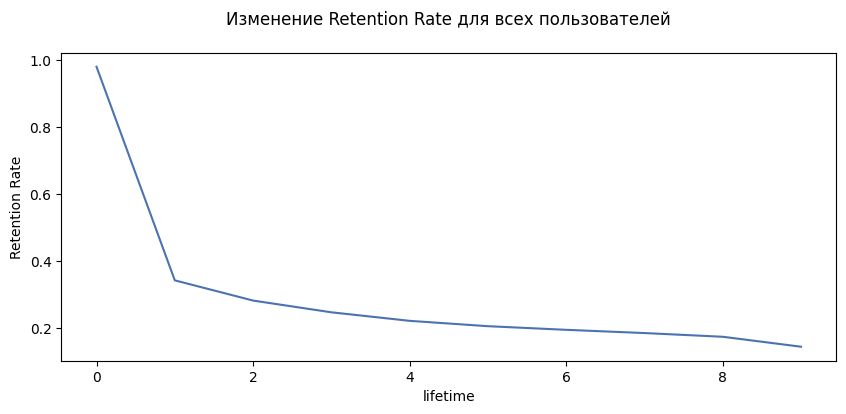

In [89]:
fig, ax = plt.subplots()
fig.set(size_inches=(10, 4))
sns.set_palette('deep')

sns.lineplot(x=retention_rate.columns, y=retention_rate.loc['total', :], ax=ax);
ax.set(ylabel='Retention Rate', xlabel='lifetime', title='Изменение Retention Rate для всех пользователей\n');

- Наиболее резкое падение на второй день использования: остается менее 40 % изначальных пользователей
- Начиная со второго дня происходит плавное снижение до значение 0.14 на 10-ый день использования

Рассчитаем и визуализируем среднее количество времени в приложении по пользователям:

In [90]:
avg_time_spent = pd.DataFrame(index=['total'], dtype='float')
for i in lifetimes:
    avg_time_spent[i] = lifetime_time_spent[i].mean()
avg_time_spent

,0,1,2,3,4,5,6,7,8,9
total,44.73,42.42,41.38,42.00,42.32,42.38,43.42,43.99,45.82,33.39


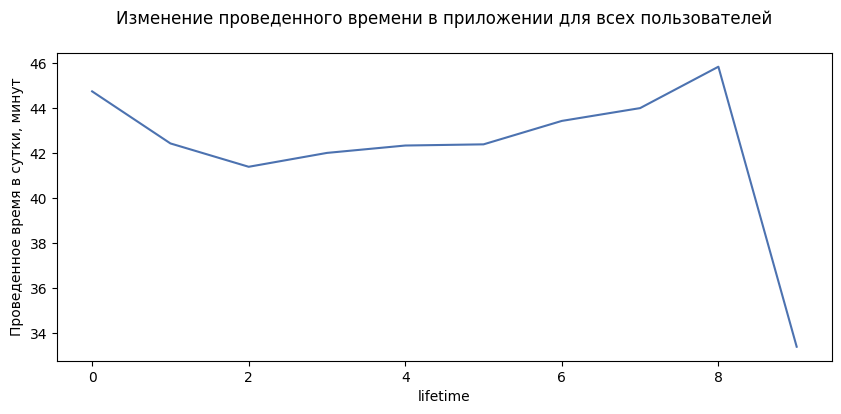

In [91]:
fig, ax = plt.subplots()
fig.set(size_inches=(10, 4))

sns.lineplot(x=avg_time_spent.columns, y=avg_time_spent.loc['total', :], ax=ax);
ax.set(ylabel='Проведенное время в сутки, минут', xlabel='lifetime', title='Изменение проведенного времени в приложении для всех пользователей\n');

- Можно утверждать, что пользователи проводят почти одинаковое время в приложении изо дня в день: около 42-х минут
- Исключение составляет 10-ый день: здесь значение достигает только 33-х минут

### Переходы с уровня на уровень

Рассчитаем и визуализируем, сколько в среднем пользователи тратят времени на получение очередного уровня:

In [92]:
levels_values = levels_pivot_time.columns

avg_time_for_level = pd.DataFrame(index=['total'], dtype='float')
for i in levels_values:
    avg_time_for_level[i] = levels_pivot_time[i].mean()
avg_time_for_level

,2,3,4,5,6,7,8,9,10,11,12,13,14,15
total,3.61,4.20,6.33,16.87,16.58,13.65,28.77,92.19,135.70,168.19,205.09,215.60,227.04,242.96


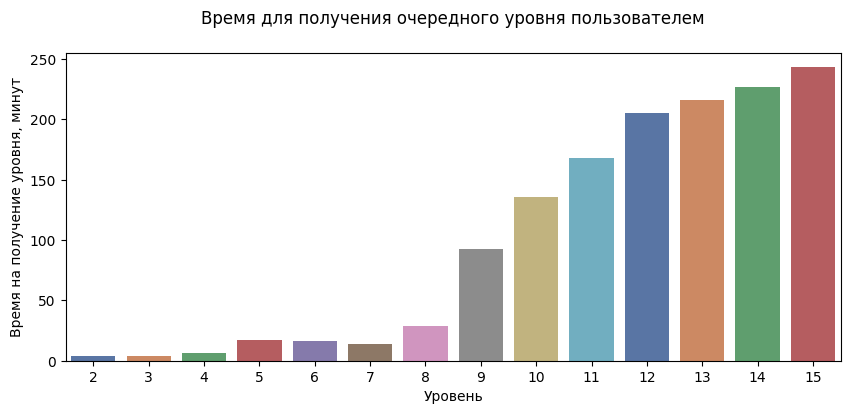

In [93]:
fig, ax = plt.subplots()
fig.set(size_inches=(10, 4))

sns.barplot(x=avg_time_for_level.columns, y=avg_time_for_level.loc['total', :], ax=ax, palette='deep');
ax.set(ylabel='Время на получение уровня, минут', xlabel='Уровень', title='Время для получения очередного уровня пользователем\n');

Сложность уровней для пользователей можно условно разбить на три интервала:
- Простые -- со второго по четвертый
- Средние -- с пятого по восьмой
- Сложные -- с девятого и далее

### Метрики монетизации

Рассчитаем ряд метрик монетизации для приложения:
- LTV/ARPU 
- ARPPU
- CR
- Средний чек

#### LTV

- Найдем средний накопленный доход на пользователя по лайфтаймам
- Для этого найдем сумму дохода со всех пользователей в каждый лайфтайм, затем посчитаем сумму с накоплением по строке и разделим на общее количество пользователей

In [94]:
lifetime_revenue = lifetime_revenue.fillna(0)
lifetime_revenue.head()

lifetime,0,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,,
2586,0.00,0.20,0.00,0.00,0.00,0.00,0.40,0.40,0.40,0.00
4609,0.00,0.00,0.00,0.10,0.00,0.00,0.00,0.00,0.00,0.00
6500,0.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6578,0.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6906,0.00,0.00,0.00,0.00,0.00,0.00,0.10,0.00,0.00,0.00


In [95]:
LTV = pd.DataFrame(index=['total', 'total_cumulative', 'LTV'], dtype='float')
for i in lifetimes:
    LTV.loc['total', i] = lifetime_revenue[i].sum()
LTV

,0,1,2,3,4,5,6,7,8,9
total,117.62,53.99,28.23,29.33,32.95,19.43,19.33,20.33,27.96,11.42
total_cumulative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LTV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
LTV.loc['total_cumulative', :] = LTV.loc['total', :].cumsum()
LTV

,0,1,2,3,4,5,6,7,8,9
total,117.62,53.99,28.23,29.33,32.95,19.43,19.33,20.33,27.96,11.42
total_cumulative,117.62,171.61,199.84,229.18,262.13,281.56,300.89,321.22,349.18,360.60
LTV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
LTV.loc['LTV', :] = LTV.loc['total_cumulative', :] / users.shape[0]

(LTV.T
 .reset_index()
 .rename(columns={'index':'lifetime'})
 .style.format({'lifetime':'{:.0f}', 
                'total':'{:.2f}', 
                'total_cumulative':'{:.2f}', 
                'LTV':'{:.4f}'}))

,lifetime,total,total_cumulative,LTV
0,0,117.62,117.62,0.0039
1,1,53.99,171.61,0.0056
2,2,28.23,199.84,0.0066
3,3,29.33,229.18,0.0075
4,4,32.95,262.13,0.0086
5,5,19.43,281.56,0.0092
6,6,19.33,300.89,0.0099
7,7,20.33,321.22,0.0106
8,8,27.96,349.18,0.0115
9,9,11.42,360.60,0.0118


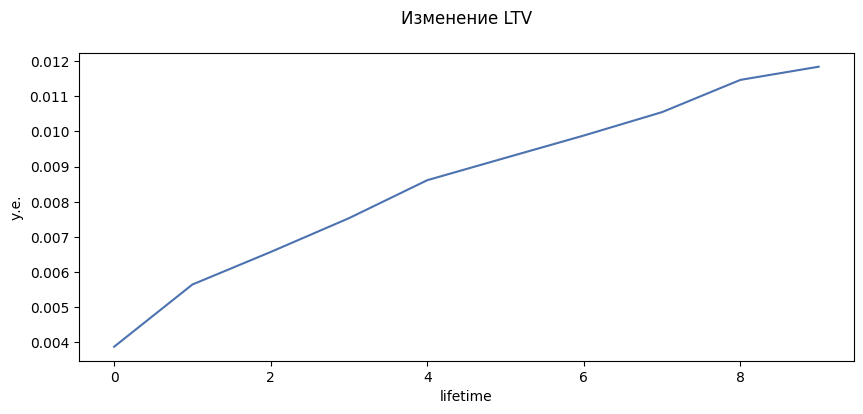

In [98]:
fig, ax = plt.subplots()
fig.set(size_inches=(10, 4))

sns.lineplot(x=LTV.columns, y=LTV.loc['LTV', :], ax=ax);
ax.set(ylabel='у.е.', xlabel='lifetime', title='Изменение LTV\n');

- LTV имеет ожидаемый вид с постепенным ростом
- На 10-ый день использования пользователь в среднем приносит немного менее 0.012 у.е.

#### ARPPU

- Рассчитаем средний доход с платящего пользователя
- Расчет аналогичен расчету LTV, но делить будем на накопленное количество платящих пользователей когорты

In [99]:
ARPPU = LTV.copy()
ARPPU = ARPPU.loc[:'total_cumulative', :]
ARPPU

,0,1,2,3,4,5,6,7,8,9
total,117.62,53.99,28.23,29.33,32.95,19.43,19.33,20.33,27.96,11.42
total_cumulative,117.62,171.61,199.84,229.18,262.13,281.56,300.89,321.22,349.18,360.60


In [100]:
for i in lifetimes:
    ARPPU.loc['payers', i] = lifetime_first_payment[i].sum()
    ARPPU.loc['ARPPU', i] = ARPPU.loc['total_cumulative', i] / ARPPU.loc['payers', i]
ARPPU

,0,1,2,3,4,5,6,7,8,9
total,117.62,53.99,28.23,29.33,32.95,19.43,19.33,20.33,27.96,11.42
total_cumulative,117.62,171.61,199.84,229.18,262.13,281.56,300.89,321.22,349.18,360.60
payers,150.00,178.00,204.00,222.00,243.00,256.00,264.00,272.00,277.00,279.00
ARPPU,0.78,0.96,0.98,1.03,1.08,1.10,1.14,1.18,1.26,1.29


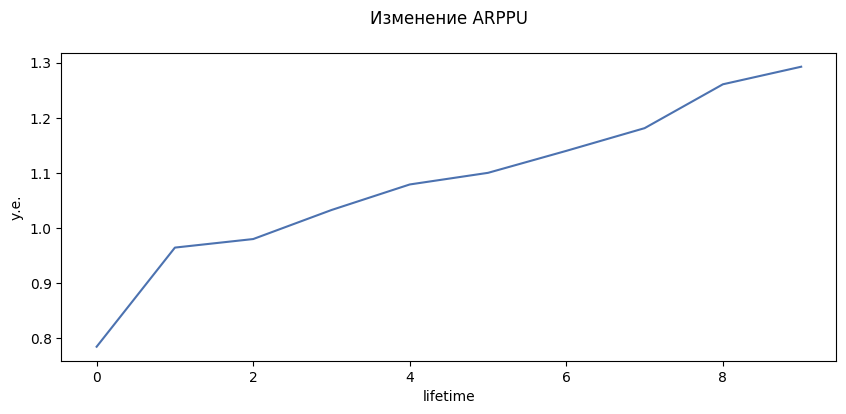

In [101]:
fig, ax = plt.subplots()
fig.set(size_inches=(10, 4))

sns.lineplot(x=ARPPU.columns, y=ARPPU.loc['ARPPU', :], ax=ax);
ax.set(ylabel='у.е.', xlabel='lifetime', title='Изменение ARPPU\n');

Средний платящий пользователь к концу десятого дня приносит 1.29 у.е.

#### Conversion Rate

- Рассчитаем конверсию как накопленную долю пользователей, ставших платящими:

In [102]:
CR = pd.DataFrame(index=['payers_cumulative', 'CR'], dtype='float')
for i in lifetimes:
    CR.loc['payers_cumulative', i] = lifetime_first_payment[i].sum()
    CR.loc['CR', i] = CR.loc['payers_cumulative', i] / users.shape[0]
    
CR = CR.T.reset_index().rename(columns={'index':'lifetime'})

CR.style.format({'lifetime':'{:.0f}', 'payers_cumulative':'{:.0f}', 'CR':'{:.2%}'})

,lifetime,payers_cumulative,CR
0,0,150,0.49%
1,1,178,0.58%
2,2,204,0.67%
3,3,222,0.73%
4,4,243,0.80%
5,5,256,0.84%
6,6,264,0.87%
7,7,272,0.89%
8,8,277,0.91%
9,9,279,0.92%


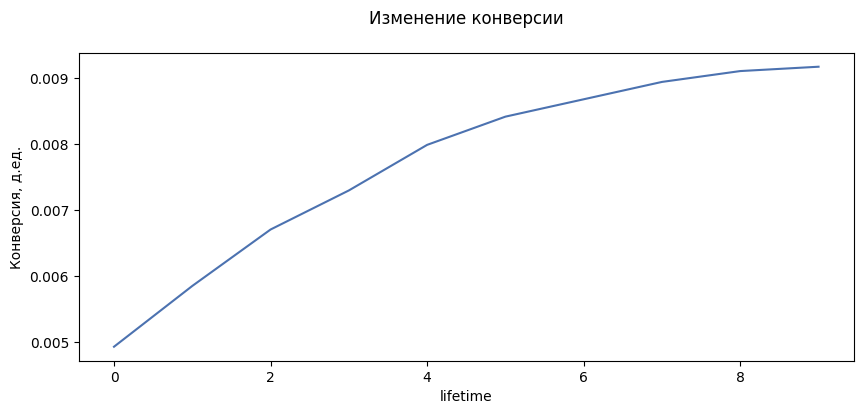

In [103]:
fig, ax = plt.subplots()
fig.set(size_inches=(10, 4))

sns.lineplot(x=CR.lifetime, y=CR.CR, ax=ax);
ax.set(ylabel='Конверсия, д.ед.', xlabel='lifetime', title='Изменение конверсии\n');

Конверсия на 10-ый день достигает 0.92 %

#### Средний чек

Рассчитаем накопленный средний чек:

In [104]:
AC = ARPPU.copy()
AC = AC.loc[:'total_cumulative', :]

for i in lifetimes:
    AC.loc['transactions', i] = lifetime_transaction_count[i].sum()
AC.loc['transactions_cumulative', :] = AC.loc['transactions', :].cumsum()
AC.loc['AC', :] = AC.loc['total_cumulative', :] / AC.loc['transactions_cumulative', :]
AC

,0,1,2,3,4,5,6,7,8,9
total,117.62,53.99,28.23,29.33,32.95,19.43,19.33,20.33,27.96,11.42
total_cumulative,117.62,171.61,199.84,229.18,262.13,281.56,300.89,321.22,349.18,360.60
transactions,229.00,69.00,53.00,55.00,48.00,30.00,26.00,33.00,24.00,12.00
transactions_cumulative,229.00,298.00,351.00,406.00,454.00,484.00,510.00,543.00,567.00,579.00
AC,0.51,0.58,0.57,0.56,0.58,0.58,0.59,0.59,0.62,0.62


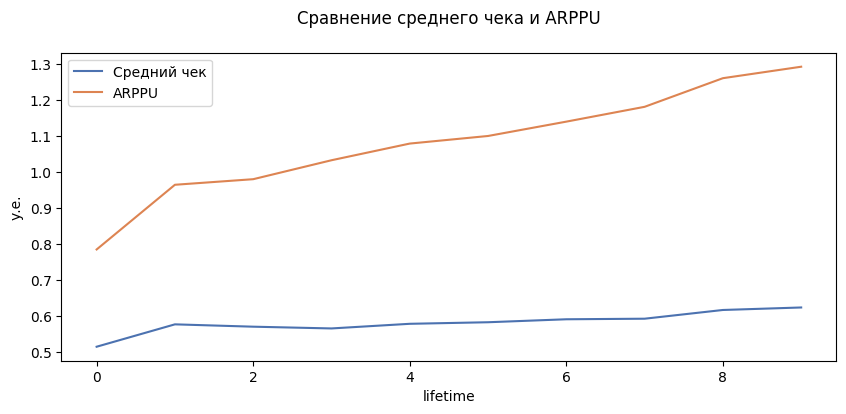

In [105]:
fig, ax = plt.subplots()
fig.set(size_inches=(10, 4))

sns.lineplot(x=AC.columns, y=AC.loc['AC', :], ax=ax, label='Средний чек');
sns.lineplot(x=ARPPU.columns, y=ARPPU.loc['ARPPU', :], ax=ax, label='ARPPU');
ax.set(ylabel='у.е.', xlabel='lifetime', title='Сравнение среднего чека и ARPPU\n');

- Из графика видно, что средний чек в любой лайфтайм ниже ARPPU
- Этот факт говорит о том, что пользователи, в среднем, совершают больше одной покупки
- Такое большое отличие показателей говорит о том, что пользователи совершают значительно больше одной покупки

### Распределение платежей по уровням

Рассмотрим суммарные траты и суммарное количество транзакций пользователей по уровням:

In [106]:
total_payments_amt_per_level = pd.DataFrame(index=['total'], dtype='float')
total_transaction_cnt_per_level = pd.DataFrame(index=['total'], dtype='float')
for i in levels_values:
    total_payments_amt_per_level[i] = levels_pivot_payments_amt[i].sum()
    total_transaction_cnt_per_level[i] = levels_pivot_payments_cnt[i].sum()
    
display(total_payments_amt_per_level)
total_transaction_cnt_per_level

,2,3,4,5,6,7,8,9,10,11,12,13,14,15
total,0.00,3.41,3.90,30.15,13.69,10.21,14.20,84.32,65.61,42.66,20.53,8.31,4.91,1.60


,2,3,4,5,6,7,8,9,10,11,12,13,14,15
total,0.00,2.00,7.00,41.00,53.00,17.00,42.00,131.00,91.00,61.00,28.00,11.00,8.00,4.00


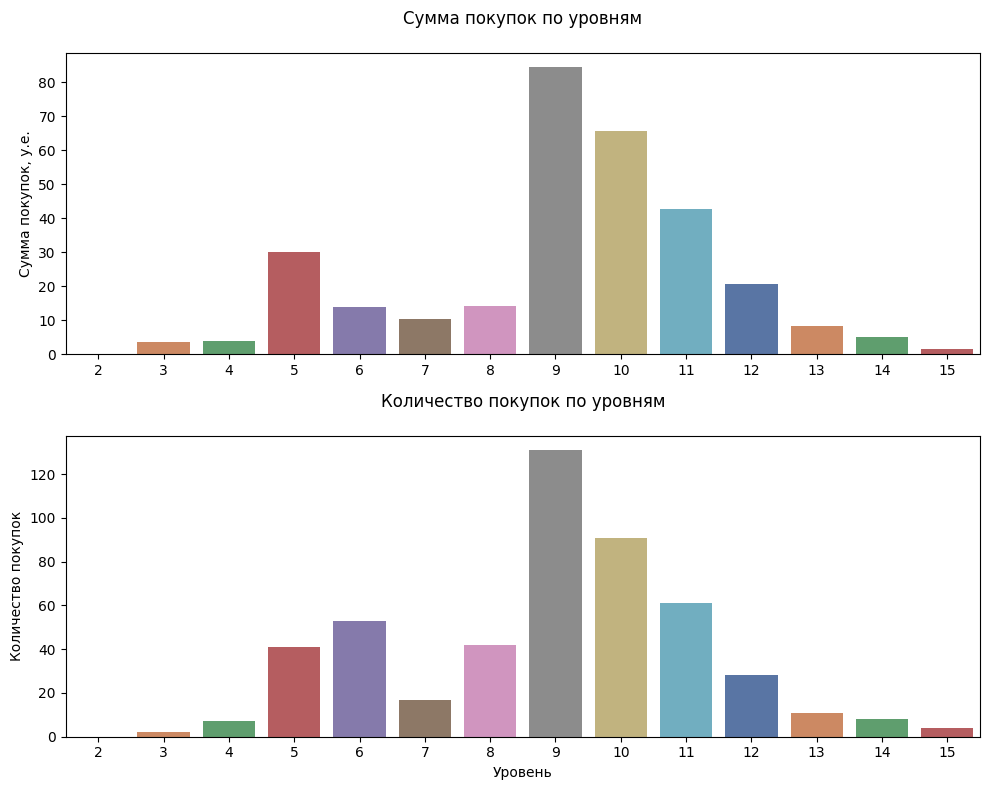

In [107]:
fig, ax = plt.subplots(2, 1)
fig.set(size_inches=(10, 8), tight_layout=True)

sns.barplot(x=total_payments_amt_per_level.columns, 
            y=total_payments_amt_per_level.loc['total', :], 
            ax=ax[0], 
            palette='deep');
ax[0].set(ylabel='Сумма покупок, у.е.', 
          xlabel=None, 
          title='Сумма покупок по уровням\n');

sns.barplot(x=total_transaction_cnt_per_level.columns, 
            y=total_transaction_cnt_per_level.loc['total', :], 
            ax=ax[1], 
            palette='deep');
ax[1].set(ylabel='Количество покупок', 
          xlabel='Уровень', 
          title='Количество покупок по уровням\n');

- Количество покупок по уровням почти совпадает с суммой покупок по уровням
    - Исключением является шестой уровень: по количеству покупок он обгоняет пятый, но по общей сумме покупок он почти в два раза меньше
- По сумме покупок прослеживается следующая динамика:
    - На втором уровне никто не совершает покупок
    - С третьего по четвертый происходит плавный рост суммы и количества покупок
    - На пятом уровне заметен интенсивный рост количества и суммы покупок
        - Сумма покупок с пятого по седьмой/восьмой уровень падает
        - Количество покупок колеблется: растет на шестом уровне, падает на седьмом и возвращается к значению пятого уровня на восьмом
    - Девятый уровень -- абсолютный лидер как по сумме, так и по количеству покупок
    - Далее заметно падение продаж, связанное с уменьшением количества пользователей, набирающих такие высокие уровни
- Общая динамика хорошо коррелирует с затраченным временем для получения уровня (которое характеризует сложность для пользователя)

### Распределение первых платежей

In [108]:
first_payment_vs_level_cnt = first_payment_vs_level_cnt.sort_values(by='level')
first_payment_vs_level_cnt

,level,first_time_payers
9,3,2
7,4,7
2,5,38
1,6,48
5,7,10
3,8,35
0,9,55
4,10,32
6,11,8
8,12,4


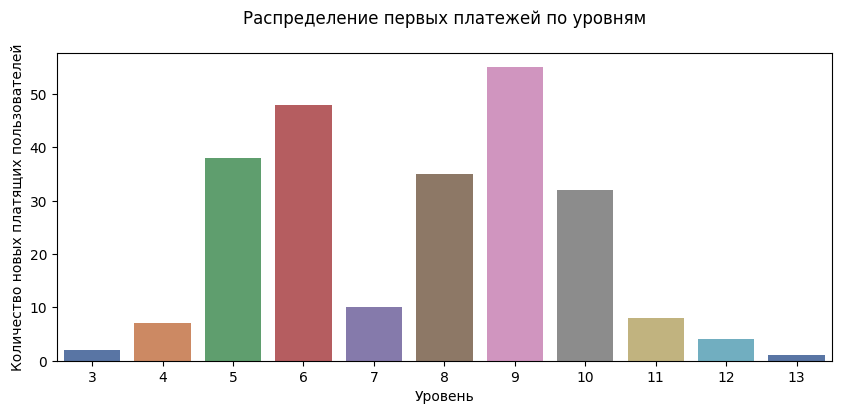

In [109]:
fig, ax = plt.subplots()
fig.set(size_inches=(10, 4))

sns.barplot(data=first_payment_vs_level_cnt, x='level', y='first_time_payers', ax=ax, palette='deep');
ax.set(ylabel='Количество новых платящих пользователей', xlabel='Уровень', title='Распределение первых платежей по уровням\n');

- Для большинства пользователей первая покупка приходится на девятый уровень
- На втором месте шестой уровень
- Следом идет уровень № 5

## Общие выводы

**Наиболее значимые метрики для приложения**

Финансовая модель приложения представляется следующей:

1) Подсказки стоят денег -> пользователи платят, когда им сложно -> чем сложнее уровни, тем лучше для приложения
2) Если сложность слишком высока, то пользователи часто испытывают негатив и вынуждены часто платить -> повышается риск потери пользователя и снижение лояльности

Ключ к стратегии развития приложения -- найти баланс сложности, при котором пользователи получают образовательные результаты, довольны приложением, но совершают покупки, принося прибыль.

Исходя из этих рассуждений и доступных данных следующие метрики являются ключевыми:

- Время получения уровня
- Retention Rate
- ARPPU
- Средний чек

**Дополнительные метрики**

Следует учитывать стоимость приобретения новых пользователей в зависимости от канала трафика: это позволит оптимизировать маркетинговую стратегию

Дополнительные метрики:
- CAC
- ROI / ROMI

**Данные для дополнительных метрик**

Рекомендуется добавить в профили пользователей источник трафика и собирать информацию о рекламных кампаниях: даты проведения, источник трафика, стоимость